In [1]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import spurt.graph
import spurt.mcf


def plot_graph(
    n: int,
    bw: int,
    ax: plt.Axes | None = None,
    edge_labels: list | None = None,
    **draw_kwargs,
):
    """Draw a planar graph using Networkx and matplotlib."""
    g = nx.Graph()
    for ii in range(n):
        g.add_node(ii)

    for ii in range(n):
        for jj in range(ii + 1, min(n, ii + bw + 1)):
            g.add_edge(ii, jj)

    if ax is None:
        fig, ax = plt.subplots()
    pos = nx.planar_layout(g)
    nx.draw(g, pos=pos, with_labels=True, ax=ax, **draw_kwargs)

    if edge_labels is not None:
        edge_label_dict = dict(zip(g.edges, edge_labels, strict=True))
        nx.draw_networkx_edge_labels(G=g, pos=pos, edge_labels=edge_label_dict)
    return g, pos, fig, ax


def plot_hop3_graph(graph: spurt.graph.Hop3Graph):
    """Draw the planar graph for one `Hop3Graph`."""
    return plot_graph(graph.npoints, bw=3)


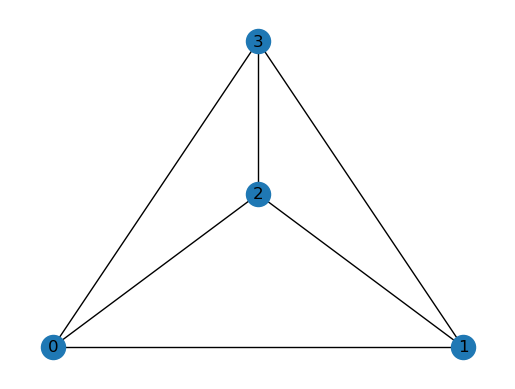

In [2]:
plot_graph(N=4, bw=3);

(<networkx.classes.graph.Graph at 0x178c08110>,
 {0: array([-1.   , -0.375]),
  1: array([ 1.   , -0.375]),
  2: array([0.   , 0.125]),
  3: array([0.   , 0.625])},
 <Figure size 640x480 with 1 Axes>,
 <Axes: >)

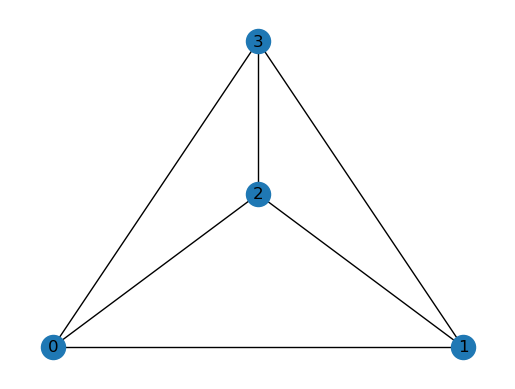

In [3]:


N = 4
g_time = spurt.graph.Hop3Graph(N)
plot_hop3_graph(g_time)

In [4]:
nifgs = len(g_time.links)
nlinks = 1  # 1 spatial link
grad_space = np.zeros((nifgs, nlinks), dtype=np.float32)
unwrapped_grad_space = grad_space.copy()
print(grad_space.shape)

(6, 1)

In [5]:
def rewrap_to_2pi(d):
    """Rewrap a phase value to be in the range [-pi, pi]."""
    return d - np.round(d / (2 * np.pi)) * 2 * np.pi

In [6]:
true_phase = 2 * np.pi * np.array([0.0, 0.2, 0.4, 0.6])
for ifg_idx, (i, j) in enumerate(itertools.combinations(range(N), r=2)):
    unwrapped_grad_space[ifg_idx] = true_phase[j] - true_phase[i]
    grad_space[ifg_idx] = rewrap_to_2pi(true_phase[j] - true_phase[i])

In [7]:
# Print the gradients in time (in cycles)
print(unwrapped_grad_space / 2 / np.pi)
print(grad_space / 2 / np.pi)

[[0.2]
 [0.4]
 [0.6]
 [0.2]
 [0.4]
 [0.2]]

[[ 0.2]
 [ 0.4]
 [-0.4]
 [ 0.2]
 [ 0.4]
 [ 0.2]]

In [8]:
# see EMCFSolver.unwrap_gradients_in_time

solver_time = spurt.mcf.ORMCFSolver(g_time)
# Compute residues for each cycle in temporal graph
# Easier to loop over interferograms here
ncycles = len(solver_time.cycles)
grad_sum = np.zeros((1, ncycles + 1), dtype=np.float32)
for ii in range(nifgs):
    # Cycles that ifg contributes to
    cyc = np.abs(solver_time.dual_edges[ii])
    cyc_dir = solver_time.dual_edge_dir[ii]
    grad_sum[:, cyc[0]] += cyc_dir[0] * grad_space[ii]
    if cyc[1] != 0:
        grad_sum[:, cyc[1]] += cyc_dir[1] * grad_space[ii]

residues = np.rint(grad_sum / (2 * np.pi)).astype(int)
# Set grounding node
residues[:, 0] = -np.sum(residues[:, 1:], axis=1)

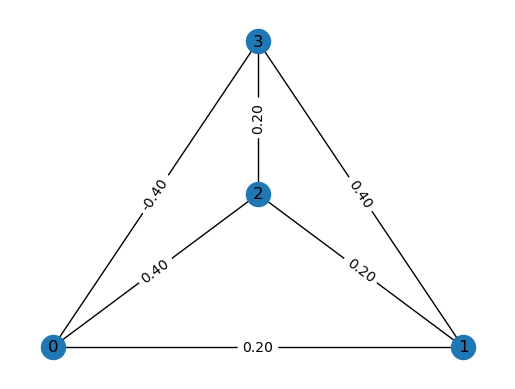

In [9]:
labels = [f"{grad / 2 / np.pi:.2f}" for grad in grad_space.ravel()]
G, pos, fig, ax = plot_graph(4, 3, edge_labels=labels)

In [10]:
print(f"Cycle indices:\n{g_time.cycles}:")
print(f"Residues for the {len(g_time.cycles)} cycles: {residues.ravel()[1:]}")
# Note: the first cycle is the boundary cycle
print(f"Boundary cycle: {g_time.boundary} , has {residues.ravel()[0]} residue")

Cycle indices:
[[0 1 2]
 [0 2 3]
 [1 3 2]]:

Residues for the 3 cycles: [0 1 0]

Boundary cycle: [[0 1]
 [1 3]
 [3 0]] , has -1 residue

In [11]:
cost = np.ones((nifgs, 1), dtype=int)
# flows = solver_time.residues_to_flows_many(residues=residues, cost=cost)
flows = solver_time.residues_to_flows(residues=residues.ravel(), cost=cost.ravel())
print(flows)

[0 0 1 0 0 0]

In [14]:
print("Original wrapped phase difference for the link:")
print(grad_space.ravel())

print("True unwrapped phase differences:")
print(unwrapped_grad_space.ravel())
print("Result after temporally unwrapping:")
print(grad_space.ravel() + 2 * np.pi * flows)

Original wrapped phase difference for the link:

[ 1.2566371  2.5132742 -2.5132742  1.2566371  2.5132742  1.2566371]

True unwrapped phase differences:

[1.2566371 2.5132742 3.7699113 1.2566371 2.5132742 1.2566371]

Result after temporally unwrapping:

[1.2566371  2.51327419 3.76991111 1.2566371  2.51327419 1.2566371 ]

We see that the true phase differences for the single link were found from temporally unwrapping.

When we move to the spatial 2D unwrapping step, we have a better starting point than directly using the wrapped phase gradients.